<img src="ntnu.jpg" width="200">

###### INGT1001: Prosjektinnlevering - fagnært prosjekt
# Analyse og databehandling: Global værmålinger og sensordata 
* *Lund, E - Heen, A - Lapiz, L - Johnsen, T - Hessen, K - Aesar, I* 

## Introduksjon
I vår oppgave som omhandler databehandling fra forskjellige sensorer skal Raspberry Pi og Sense hat modulen, ved bruk av tilgjengelig data og feilkilder beregne en tilnærmet temperatur, i tillegg til ulike fenomener i naturen.

1. Raspberry Pien og Sense hat ligger begge sammen i ett etui, laget av hardplast, som kan være en større feilkilde når sensorene henter data. Vi skal prøve å begrense denne feilkilden ved hjelp av flere gjennomsnittsmålinger over en gitt tid, som da loggfører sensordata i ett gitt tidsintervall. En av feilkildene som påvirker sensorene i større grad er CPU temperaturen til Raspberry Pi.
2.	Denne temperaturen skal vi bruke til å svare på hvordan menneskekroppen opplever temperaturer over 27 grader og under 0 grader, da opplevd temperatur på menneskekroppen øker og minker i samsvar med luftfuktighet og vindhastighet. Dette gjør man ved hjelp av formler i fysikk (meteorologi, og termodynamikk). De er beregnet ut ifra komplekse differensial ligninger, som samsvarer med naturen og menneskekroppen opplevde temperatur («apparent temperature»). I tillegg kjøres det en kode, som forteller temperaturen når vanndråper i luften kondenserer/fryser og former dugg/rim, også kalt duggpunkt/rimpunkt. 

Vi skal i første del av denne oppgaven svare på; hvordan man kan bruke tilgjengelige data til vår fordel til å begrense feilkildene, i tillegg til å forklare, kalkulere og bekrefte naturfenomenet dugg/rimpunkt.

### Kode: værlogger
#### Moduler
```python
from gpiozero import CPUTemperature
import time as tm
from sense_hat import SenseHat
import csv
import os.path
from datetime import datetime as dt
import numpy as np
```
Importerer de nødvendige modulene for måling og loggføring:
1. gpiozero henter temperaturen til Raspberry PI CPU
3. sense_hat gjør Sense Hat elementet og dens sensorer tilgjengellig.
4. csv gjør at loggeren kan åpne og skrive fil som .csv (comma seperated values)
5. Datetime for å hente dato og tid, for merking av logging
6. os.path vil kunne sjekke om en tilgjengellig vei til filen eksisterer
7. Numpy bidrar til matematiske funksjoner for manipulering av data

#### Variabler
Overordnede variabler tilknyttet skriptet, hvor sense er en forenkling og N beskriver antall iterasjoner sensorene vil bruke for å innhente data, tatt over ett gjennomsnitt

```python
sense = SenseHat()
N = 10
```

#### Funksjoner
Beregner gjennomsnittlig trykk, temperatur og luftfuktighet over N antall iterasjoner med 10 ms mellomrom for hver ny måling "tm.sleep(0.01)". Deretter vil gjennomsnittet lagres og returneres.
```python
def average_pressure():
    pressure_sum = 0
    for _ in range(0, N):
        pressure_sum += round(sense.get_pressure(),4)
        tm.sleep(0.01)
    pressure_avg = pressure_sum / N
    return(pressure_avg)
    
def average_temp():
    temp_sum = 0
    for i in range(0,N):
        temp_sum += sense.temp
        tm.sleep(0.01)
    temp_avg = temp_sum / N
    return(temp_avg)

def average_humid():
    humid_sum = 0
    for e in range(0, N):
        humid_sum += round(sense.get_humidity())
        tm.sleep(0.0)
    humid_avg = humid_sum / N
    return(humid_avg)
```
#### CPU temperaturen
Raspberry Pi CPUen vil kunne påvirke målingene som er innhentet, for å kalkulere vekk denne feilkilder henter gpiozero CPU temperaturen. Det ble brukt temperatur fra luftfuktighet og trykk, for å øke mengden tilgjengellig temperaturmålinger. Denne temperaturen blir senere tatt i bruk for å finne differansen mellom temperatur fra sensor og CPU (t_cpu - t). Resultatet av testing viser at et gjennomsnittet disse verdiene ga en for stor temperaturøkning. Etter videre testing ble 2/3 av differansen fratrekt fra gjennomsnittet til t1 og t2 ga best resultat til sammenligning med termostat og værmåling (yr, 2020).
```python
def get_cpu_temp():
    cpu = CPUTemperature().temperature
    cpu = float(cpu)
    return(cpu)
	
def abs_avg_temp():
    t1 = sense.get_temperature_from_humidity()
    t2 = sense.get_temperature_from_pressure()
    t_cpu = get_cpu_temp()
    t = (t1+t2)/2
    t_corr = t - ((t_cpu-t)/1.5)
    return(t_corr)
```
#### Funksjoner for varme, kuldeindeks og duggpunkt. 
- Varmeindeksen blir beregnet ut ifra komplekse differensialligninger for opplevd temperatur over 27 grader (TRENGER REF!!).
- Kuldeindeks bruker sanntid vindmålinger for å kalkulere opplevd temperatur under 0 grader (TRENGER REF!!).
- Funksjon for duggpunkt, som beregner temperaturen som skal til for at vanndråper i luften kondenserer og forårsaker dugg/tåke.


```python
def heat_index():
    t = abs_avg_temp()
    T2 = pow(t,2)
    h = average_humid()
    H2 = pow(h,2)
    C1 = [-8.78469475556, 1.61139411, 2.33854883889, -0.14611605, -0.012308094, -0.0164248277778, 0.002211732,0.00072546,  -0.000003582]
    heatindex = C1[0] + (C1[1] * t) + (C1[2] * h) + (C1[3] * t * h) + (C1[4] * T2) + (C1[5] * H2) + (C1[6] * T2 * h) + (C1[7] * t * H2) + (C1[8] * T2 * H2)
    hic = heatindex
    return(hic)

def windchill_index():
    v_261120 = 11 #[km/h]-lufthastigheten ved breddegrad 63.25° N, 10.23° E: Trondheim (ref. https://earth.nullschool.net/#current/wind/surface/level/overlay=misery_index/winkel3=10.95,63.11,8204/loc=10.474,63.428)
    V2 = pow(v_261120, -0.16)
    K = [13.12, 0.6215,-11.37,0.3965]
    windchillindex = K[0] + (K[1]*t) - (K[2]*V2) + (K[3]*t*V2)
    wic = windchillindex
    return(wic)

def dew_point():
    t_corr = abs_avg_temp()
    h = average_humid()
    d = t_corr-(14.55+0.114*t_corr)*(1-(0.01*h))-((2.5+0.007*t_corr)*(1-(0.01*h)))**3-(15.9+0.117*t_corr)*(1-(0.01*h))**14
    return(d)
```
#### Datainnsamling
Oppsamling av samtlige funksjoner data, og lagrer det til en liste (sense_data). for å unngå oppsamling av ugyldig data når kulde og varmeindeks blir listen gitt "NaN" verdier, fram til tillatt område (if/elif/else) for temperatur blir gitt og bytter ut verdien ut fra riktig element i indeks
```python
def get_all_data():
    sense_data = []
    sense_data.append(dt.now())
    sense_data.append(round(average_humid(),4))
    sense_data.append(round(average_pressure(),4))
    sense_data.append(round(average_temp(),4))
    sense_data.append(round(get_cpu_temp(),4))
    sense_data.append(round(abs_avg_temp(),4))
    sense_data.append(np.nan)
    sense_data.append(np.nan)
    sense_data.append(round(dew_point(), 4))
    if abs_avg_temp() > 27:
        sense_data[6] = round(heat_index(),4)
    elif abs_avg_temp() < 0:
        sense_data[7] = round(windchill_index(),4)
    else:
        pass
    return(sense_data)
```
#### Filhåndtering
os.path modulen bekrefter/avkrefter om filen eksisterer, hvis den ikke eksisterer skriver den kolonneoverskrifter for dataen i .csv filen, hvis ikke, vil den iterere over linjen.
```python
file_exists = os.path.isfile("dfwd1_4.csv")

with open("dfwd1_4.csv", "a") as file:
    headers = ["datetime","humidity", "pressure", "temperature", "CPU temperature", "Absolute temperature", "HI index", "WI index"]
    writehd = csv.DictWriter(file, delimiter=',', lineterminator='\n',fieldnames=headers)
    if not file_exists:
        writehd.writeheader()  # file doesn't exist yet, write a header
```
### Løkke for logging av værdata
Henter data fra samlefunksjonen og legger de til .csv filen, for å deretter "hvile" løkken i 60 sekund før den igjen tar en nye måling.
```python
while True:
    with open("dfwd1_4.csv", "a") as file:
        data = get_all_data()
        csv.writer(file).writerow(data)
        tm.sleep(60)
```

## SYSTEMD - Oppsett av bakgrunnskjøring av kode
### logger.service
```ruby
ssh pi@butterscotchpie.is-very-sweet.org
password [..]
sudo nano logger.service
```
#### I logger.service filen skriver man:
1. Når programmet skal starte i boot.
- skriptet kjører etter tilkobling til nettverk
2. Hvilket program som skal starte.
- Arbeidsmappen til koden.
- Hvilken bruker (root) som skal kjøre. root brukeren er en superbruker+ som ved feil, kan kunne overskride.
- om koden skal starte ved uforventet stopp.
3. Installasjon av programmet i boot
```ruby
[Unit]
Description = SenseHat Logger
After = network.target
```
```ruby
[Service]
ExecStart=sudo python3 /home/pi/logger/weatherlogger1_4.py
WorkingDirectory=/home/pi/logger
StandardOutput=inherit
StandardError=inherit
Restart=always
User=root
```
```ruby
[Install]
WantedBy=multi-user.target
```

#### Start logger.service:
1. Flytte filen til mappen hvor oppstartsprogram blir kjørt
2. Restarte daemon
3. Starte og teste filen
4. Påtrykke oppstart av python3 skriptet "weatherlogger1_4.py" ved boot/oppstart

```ruby
cp logger.service /etc/systemd/system/
sudo systemctl daemon-reload
sudo systemctl start logger.service
systemctl status logger.service
```

<img src="systemdstatus.png" width="400">


```ruby
sudo systemctl enable logger.service
```
Programmet vil nå starte ved oppstart av Raspberry Pi. Deretter lager skriptet en csv fil (dfwd1_4.csv), hvis den ikke eksisterer, som vil plasseres i arbeidsmappen (/home/pi/logger/).

## Framstilling og visualisering av data
I dette avsnittet skal dataen fra loggeren; behandles, framstilles og visualiseres ved hjelp verktøy som pandas og matplotlib. Det skal tolkes ved hjelp av pandas i form av et "dataframe", dette er ett viktig verktøy for databehandling av mellomstor/stor data. Det gir også tilgang på funksjoner forenkler manipulering av .csv filen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Dataframe og opprydding av data

In [2]:
df = pd.read_csv("Datasets/dfwd1_4.csv", index_col="datetime")
df.drop(df.tail(4).index,inplace=True)
df.index = df.index.str[:-7]
df.head(-1)

,humidity,pressure,temperature,CPU temperature,Absolute temperature,HI index,WI index,DW point
datetime,,,,,,,,
2020-11-25 22:32:30,38.0,995.9475,19.3329,30.558,11.1560,NaN,NaN,-2.7587
2020-11-25 22:33:39,39.0,995.8921,19.1426,31.096,10.7978,NaN,NaN,-2.6533
2020-11-25 22:34:39,39.0,995.9997,18.9990,30.020,11.2953,NaN,NaN,-2.2765
2020-11-25 22:35:39,37.2,996.0142,18.7361,30.020,10.4988,NaN,NaN,-2.7053
2020-11-25 22:36:40,38.0,996.0247,18.6335,30.020,10.6131,NaN,NaN,-3.2451
...,...,...,...,...,...,...,...,...
2020-11-27 08:04:07,34.0,1011.0054,16.2725,28.944,7.0714,NaN,NaN,-7.8777
2020-11-27 08:05:07,34.0,1011.0725,16.1196,28.406,7.0189,NaN,NaN,-7.6067
2020-11-27 08:06:08,35.0,1011.0763,16.1364,28.406,7.3359,NaN,NaN,-7.2663


### Info
værmålerens *dataframe* har datetime som indekskolonne, som inneholder 2011 dataoppføringer. Det er syv tilhørende kolonner. Kolonnenes datatyper er float64, hvor "HI index" og "WI index" inneholder 0 ikke-null. *dataframet* bruker 141.4kb lagringsplass.

In [3]:
df.info()
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])
df.apply(minMax)

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 2020-11-25 22:32:30 to 2020-11-27 08:09:09
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   humidity              2007 non-null   float64
 1   pressure              2007 non-null   float64
 2   temperature           2007 non-null   float64
 3   CPU temperature       2007 non-null   float64
 4   Absolute temperature  2007 non-null   float64
 5   HI index              0 non-null      float64
 6   WI index              0 non-null      float64
 7   DW point              2007 non-null   float64
dtypes: float64(8)
memory usage: 141.1+ KB


,humidity,pressure,temperature,CPU temperature,Absolute temperature,HI index,WI index,DW point
min,33.0,995.8921,11.6046,23.564,2.4825,NaN,NaN,-10.4693
max,67.0,1011.2416,21.4067,33.248,13.3939,NaN,NaN,-0.9929


### Tolkning av informasjonen
Det man kan lese ut ifra maksimum og minimums verdiene for målingene er at temperaturen aldri oversteg 27, eller under 0 grader. Videre så ser man resultatet av dette i kolonnene for varme og kuldeindeksen, da værmåleren ikke har kunnet gjort beregninger på disse, har de forblitt "NaN"-verdier. Dette kan man også se fra info.

### Variabler

In [4]:
df_htemp = df[["temperature","humidity","CPU temperature","Absolute temperature","HI index","WI index","DW point"]]
df_press = df["pressure"]
df_dewp = df["DW point"]

### Opprydding av *dataframe*

In [5]:
df_htemp.dropna(axis=1)

,temperature,humidity,CPU temperature,Absolute temperature,DW point
datetime,,,,,
2020-11-25 22:32:30,19.3329,38.0,30.558,11.1560,-2.7587
2020-11-25 22:33:39,19.1426,39.0,31.096,10.7978,-2.6533
2020-11-25 22:34:39,18.9990,39.0,30.020,11.2953,-2.2765
2020-11-25 22:35:39,18.7361,37.2,30.020,10.4988,-2.7053
2020-11-25 22:36:40,18.6335,38.0,30.020,10.6131,-3.2451
...,...,...,...,...,...
2020-11-27 08:05:07,16.1196,34.0,28.406,7.0189,-7.6067
2020-11-27 08:06:08,16.1364,35.0,28.406,7.3359,-7.2663
2020-11-27 08:07:08,16.1215,35.0,27.868,7.0152,-7.2326


### Plots

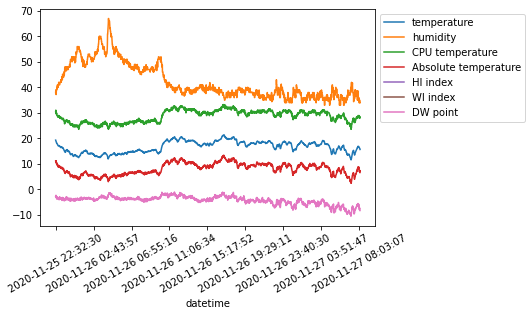

In [6]:
df_htemp.plot(rot=30)
plt.legend(bbox_to_anchor=(1, 1));

## Spørsmål 1: Redusering av feilkilder
### Resultat og diskusjon
##### Differensierer vekk CPU temperatur som feilkilde fra Raspberry Pi
For å begrense feilkildene ved måling av temperatur, gjorde vi temperaturmålingene på tre forskjellige måter. Vi brukte CPU-temperaturen til Raspberry Pien, i tillegg til temperaturen fra luftfuktighetssensoren og fra trykksensoren. Ved å bruke gjennomsnittet av alle tre, reduserer vi feilkildene ved temperaturmålingene. En av feilkildene vi ønsket å redusere, var at CPU temperaturen var for høy, både i forhold til de to andre temperaturmålingene, og i forhold til yr.no sine værstasjoner. Dette kan skyldes at Raspberry Pien produserer varme når den er på.

Ved å regne gjennomsnittet av temperaturen fra luftfuktigheten og trykket, og derretter trekke fra 2/3 av differansen mellom gjennomsnittet av temperaturen luftfuktigheten og trykket, og CPU temperaturen, kan vi redusere denne feilkilden, og logge en temperatur som er nærmere den reelle temperaturen i luften. Ved å sammenligne temperaturen vi registrerte med temperaturer fra yr.no, kan vi se at vår utregnede temperatur er nærmere yr.no sin målte temperatur, enn både CPU temperaturen og temperaturene fra Sense Hat-en.

<img src="yr.png" width="1000">
(fig. 1.1, Temperatur fra 26.11.2020, yr, 2020)

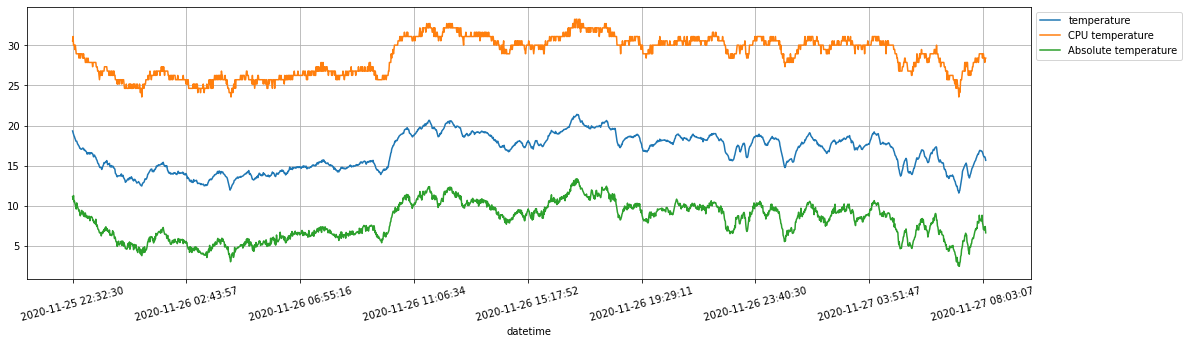

In [7]:
df_spm1 = df[["temperature","CPU temperature","Absolute temperature"]]
df_spm1.plot(rot=15, figsize=(18,5),grid = True);
plt.legend(bbox_to_anchor=(1, 1));

Vår målte temperatur er fortsatt litt høyere enn temperaturene fra yr.no, men dette kan skylles andre årsaker. En viktig årsak til at temperaturen vår er høyere, kan være fordi våre temperaturer ble målt i vinduskarmen til et soverom. Det vil si at vi får tilnærmet utetemperatur, med den blir påvirket av temperaturen inne i soverommet. I tillegg er målestasjonen til yr.no på en annen plass, så det vil være mulig at litt av forskjellen skyldes lokale forskjeller. Vi brukte Sverresborg målestasjon, som ligger litt over 2 km unna vår testlokasjon. I tillegg ligger målestasjonen 50 meter høyere over havet, som kan være med på å utgjøre en temperaturforskjell. 

### Konklusjon:
Ved å bruke flere temperaturer fra forskjellige sensorer, kan man redusere feilkilden i måleutstyret, og dermed måle en temperatur som er nærmere den reelle temperaturen enn hver av de tre temperatursensorene gir hver for seg. 

## SPØRSMÅL 2, er dataene gode nok til at vi kan vite når det dugger hos Trym?:

DW point som vi har valgt å ta med som spørsmål i oppgaven beregnes utifra forskjellige differentsiallikninger. Men i all hovedsak er duggpunktet påvirket av faktorene, temperatur, lufttrykk og relativ fukt

'Duggpunktet(DW point) er temperaturen luften må avkjøles til for at vanndamp skal kondensere til vann. Hvis temperaturen går under 0 grader, kan ikke lengre vanndampen kondensere, og vil da danne rim eller rimfrost istedenfor dugg og vi får da heller rim-punkt.'

Utifra 'OUT28', ser vi at duggpunktet alltid ligger under null og det endrer da egentlig navn til rimpunkt. Men vi kan likevel beregne rimpunkt på helt samme måte som duggpunkt og videre i oppgaven fortsetter vi rett og slett og kalle det for duggpunkt eller DEWPOINT.

For å bekrefte at det er rimpunkt og ikke duggpunkt vi snakker om så sjekker vi makstemperaturen til duggpunktet.

In [8]:
df_dewp = df["DW point"]
df_dewp.max()

-0.9929

### Duggpunkt
Duggpunkt er knyttet til det som kalles for relativ fukt. Relativ fukt brukes når man skal omtale duggpunktet, ved høy relativ fukt vil duggpunktet være tilnærmet lik lufttemperaturen. Ved 100% relativ fukt, vil lufttemperaturen være lik duggpunkttemperaturen. 

Da vil:

    T(DEWPOINT) * 100RH = T(luft)

Dette kommer til å komme ganske tydelig frem på yr sine grafer, hvor luftfuktigheten er på over 90%, da er relativ fukt så høy at lufttemperatur er tilnærmet lik DEWPOINT_temperature.

Men i tilfeller hvor RH ikke er nærme 100% slik som i vårt tilfelle så kan man finne duggpunktet ved hjelp av formelen;

#### *Generell formel*
    T(dp) = (c * y(T,RH))/( b - y(T,RH))
    c,b = konstanter
    T = absolutt temperatur
    RH = humidity
    y = gamma

In [9]:
print(df_dewp.head(5))

datetime
2020-11-25 22:32:30   -2.7587
2020-11-25 22:33:39   -2.6533
2020-11-25 22:34:39   -2.2765
2020-11-25 22:35:39   -2.7053
2020-11-25 22:36:40   -3.2451
Name: DW point, dtype: float64


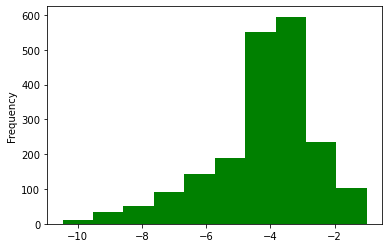

In [10]:
df_dewp.plot.hist(color="g");

(fig 1.1, forekomst av dugg/rimpunkt temperatur)

Her ser vi hvilke temperaturer duggpunktet er innom. 
duggpunktet ligger på mellom -3 og -4 aller mest, men er også oppe i -10 på sitt minste.

In [11]:
print(df_htemp["Absolute temperature"].head(5))
print(df_htemp["humidity"].head(5))

datetime
2020-11-25 22:32:30    11.1560
2020-11-25 22:33:39    10.7978
2020-11-25 22:34:39    11.2953
2020-11-25 22:35:39    10.4988
2020-11-25 22:36:40    10.6131
Name: Absolute temperature, dtype: float64
datetime
2020-11-25 22:32:30    38.0
2020-11-25 22:33:39    39.0
2020-11-25 22:34:39    39.0
2020-11-25 22:35:39    37.2
2020-11-25 22:36:40    38.0
Name: humidity, dtype: float64


##### DATA FRA YR.no

<img src="yr.png" width="1000">

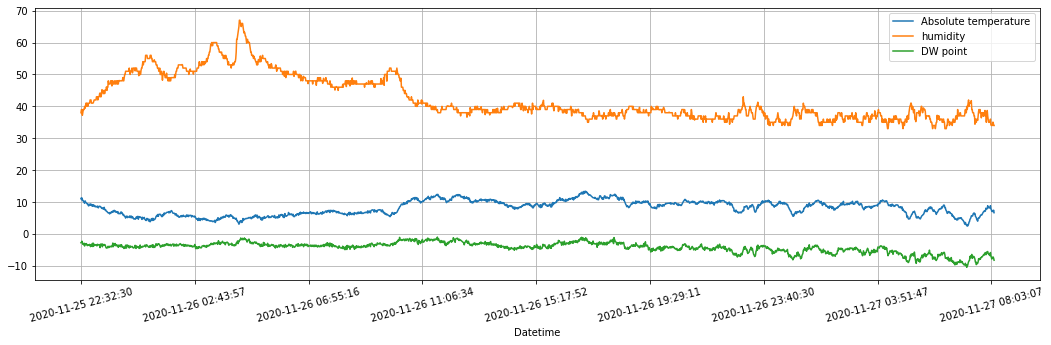

In [12]:
df_htemp[["Absolute temperature","humidity", "DW point"]].plot(rot=15, figsize=(18,5), grid=True, xlabel="Datetime");          
plt.legend(bbox_to_anchor=(1, 1));

(fig 1.2, oversikt temperatur)

liten oversikt som viser tall fra humidity og temperatur.

### Diskusjon:

Hvis vi ser på dataene fra grafen ser vi at når luftfuktigheten ("Humidity") stiger, grenser T(dp) mot T(Luft), som ved maksverdien til luftfuktighet. Resultatet er at duggpunktet (DW POINT) har en korrelasjon når det nærmer seg T(luft), og dermed samvarierer.

Det er også å merke seg på grafen så vil T bli lavere idet H blir større, som også sammentreffer med data fra Yr (fig 2.1). På vinteren er H veldig høy, som gjør at duggpunktet er veldig nærme T(luft). Dataene fra yr bekrefter også dette ved at når temperaturen nærmer seg 0 så blir H nærmere og nærmere 100%.

de plutselige svingningene i temperatur og fuktighet kan se unaturlige ut, og kan skyldes ytre påvirkning utenom det vi har målt, som vi har nevnt i feilkildene.

#### Stemmer dataene med de fra yr.no?

Hvis vi sammenligner temperaturgrafene til yr, kan vi se at temperaturen vi selv har målt, ikke stemmer helt med målingene, vi antar nøyaktige, fra yr. økningen klokka 7 på morgenen er unaturlig bratt og stemmer ikke overens med yr som gjør det naturlig å anta at en feilkilde kommer inn og ødelegger 

Faktorer som kan påvirke er ytre faktorer, som overnevnt er feilkilder allerede diskutert, som man ikke har, eller kan påvirke. Ett mulig problem er at ovnen står rett under vinduet som pien lå utenfor og det kan dermed ha skjedd en påvirkning derifra når ovnen skrudde seg på rundt 6-7 tiden. En annen problemstilling var at vinduet bli justert.Ellers kan en åpning av vinduet(hvis Trym feks skulle sjekke om alt gikk fint med pien) ha gjort at det kom en unaturlig tilstrømning av varme.

Likevel får vi en ganske bra måling, ettersom vi har en stor feilkilde i CPU temperaturen som vi får fjernet og dermed likevel ha en god måling på temperaturen som vi kan benytte oss av til oppgaven. 

På den andre siden, viser resultatene et samsvar med data fra yr, senere på dagen den 26. november (fig 1.1)(fig 1.2).

Her kan man se at fra klokka (11:06) og til (23:40) den 26. ser vi at vi har et stadig fall i temperatur, selv om det kommer litt "brå" stigninger eller fall, og dette sammesvarer med yr sine målinger om at fra klokka.12 så faller det helt frem til 00 på kvelden den 26. Dermed kan vi konkludere med at vi har en ok sammenlignbar måling med yr sine statestikker, hvis vi ser bortifra de plutselige temperatursvingningene

In [13]:
avg_DWPOINT = df["DW point"].mean()
print(avg_DWPOINT)

-4.228464773293475


Her kan man se at fra klokka (11:06) og til (23:40) den 26. ser vi at vi har et stadig fall i temperatur, selv om det kommer litt "brå" stigninger eller fall, og dette sammesvarer med yr sine målinger om at fra klokka.12 så faller det helt frem til 00 på kvelden den 26. Dermed kan vi konkludere med at vi har en ok sammenlignbar måling med yr sine statestikker, hvis vi ser bortifra de plutselige temperatursvingningene

Dessverre kan vi se at målingene våre er helt off hvis vi ser på luftfuktigheten vi målte i forhold til yr sin. dette er nok pga det åpne vinduet til trym, som slipper ut hans innestengte luft, som ganske sikkert har ganske lav luftfuktighet hm mon tro hvorfor(wink). Hvis vi ser på gjennomsnittsforskjellen på våre data og yr sine ser vi at vi har utslag på 20-30% feil... Dette gir dessverre en ganske stor feilkilde som påvirker alle resultatene...

### Konklusjon: 

Vi kan dermed konkludere med at vi har fått pien til å virke på den måten vi selv vil. Vi fikk et greit nok svar på DEWPOINT, som stemmer greit overens med målinger gjort av yr. 

For at vi skulle klare å regne ut DEWPOINT var vi avhengige av riktig temperatur og luftfuktighet. Ved å fjerne den store feilkilden i CPU-Temp, fikk vi en god temperaturverdi. 

Dewpoint ligger veldig lavt, som kan være på grunn av flere faktorer enn bare utetemperaturen, vi har funnet flere feilkilder, som det naturlig nok har vært men vi har klart på en god måte å fjerne CPU temp og andre faktorer som gjør at vi får en rimelig nøyaktig måling på temperaturen, som da igjen kan brukes for å finne DEWPOINT.

Dessverre blir luftfuktigheten en veldig stor feilkilde ettersom denne ikke stemmer med yr i det hele tatt og vårt DEWPOINT blir da mye lavere, går under 0grader, mens yr sin ligger på 1-4% unna ute temperaturen.

- Så temperaturen er kanskje det som er mest riktig.

- Luftfuktigheten er 20-30% feil i forhold til yr, og dermed påvirker dette DEWPOINT negativt ved at dewpoint blir under 0 grader.

- DEWPOINT blir riktignok feil grunnet luftfuktigheten, men er bare 3-6% avvik. viktigste forskjellen er at den egentlig skulle ha vært over 0grader C.

Ved siden av det så kan vi konkludere med at siden temperatur og dewpoint overall synker - så går det mot vintersesong.

### Bibliografi
https://www.yr.no/nb/historikk/graf/1-557592/Norge/Tr%C3%B8ndelag/Trondheim/By%C3%A5sen?q=2020-11-26 (nedlastet 07.12.2020 kl 14:14